In [24]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns',36)

Once you’ve built your model, use an open-source app framework of your choice (e.g., Streamlit, Hex, etc) to turn your algorithm into a data-app that can be used to illustrate your model (e.g., inputs, outputs, visualizations, etc). You are free to illustrate your model via the data-app in whatever way you think is suitable. Think of business users as your audience.

Please include in your solution answers to the following questions:
1. In two or three paragraphs, please describe your methodological approach to the problem (e.g., how you framed the problem, any assumptions you made, why you chose certain techniques, etc). If applicable, please include any references to the literature that you used.
2. In 3 bullet points, please explain what feedback you'd give to the engineering team responsible for the data API to help them improve any aspect of the tool that you think would benefit.
3. In 3 bullet points, please give guidance to the business regarding any suggestions you'd give them for using this model in production.
4. What two things would you do to improve this test? One line for each.

In [2]:
df = pd.read_csv('Technical_Task_Dataset.csv')

The data set seems to have some misentered data, with post codes in the Latest Accounts Date and negative numbers in the Account Year. To address this, I restircted the Account Year variable to values between 1900 and 2023 (it appears 1983 is the first so this covers all available  data). The variables types were then automatically detected and checked.

In [3]:
df2 = df[df.index.isin(df.query('1900 < `Account Year` < 2023').index)]
display(df2.shape)

df2=df2.convert_dtypes()
df2.info()

(68575, 36)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68575 entries, 0 to 68649
Data columns (total 36 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Registered Number                                68575 non-null  string 
 1   Date of Incorporation                            68570 non-null  string 
 2   Latest Accounts Date                             68575 non-null  string 
 3   Account Year                                     68575 non-null  Int64  
 4   Trading Status                                   68575 non-null  string 
 5   UK SIC Code                                      68575 non-null  Int64  
 6   Registered or Trading Postcode                   68490 non-null  string 
 7   Bank Overdraft                                   35944 non-null  Int64  
 8   Bank Postcode                                    28960 non-null  string 
 9   Capital Expenditure         

The next step was to convert the dates to a datetime. The for loop below checks all strings and converts those that do not return a value error to datetime64[ns].

In [4]:
df3 = df2.copy()
for col in df3.columns:
    if df3[col].dtype == 'string':
        try:
            df3[col] = pd.to_datetime(df2[col])
        except ValueError:
            pass
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68575 entries, 0 to 68649
Data columns (total 36 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Registered Number                                68575 non-null  string        
 1   Date of Incorporation                            68570 non-null  datetime64[ns]
 2   Latest Accounts Date                             68575 non-null  datetime64[ns]
 3   Account Year                                     68575 non-null  Int64         
 4   Trading Status                                   68575 non-null  string        
 5   UK SIC Code                                      68575 non-null  Int64         
 6   Registered or Trading Postcode                   68490 non-null  string        
 7   Bank Overdraft                                   35944 non-null  Int64         
 8   Bank Postcode                       

Next the data is restricted to only the last financial year (i.e., "Account Year" = year in "Latest Accounts Date").

In [5]:
df4 = df3[df3['Latest Accounts Date'].dt.year==df3['Account Year']]
df4['Years'] = df4['Account Year']-df4['Date of Incorporation'].dt.year
df4['Years']= df4['Years'].astype(int)
df4.shape

C:\Users\Brandi\AppData\Local\Temp/ipykernel_10600/3681883468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Years'] = df4['Account Year']-df4['Date of Incorporation'].dt.year
C:\Users\Brandi\AppData\Local\Temp/ipykernel_10600/3681883468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Years']= df4['Years'].astype(int)


(13715, 37)

In [6]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13715 entries, 0 to 68645
Data columns (total 37 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Registered Number                                13715 non-null  string        
 1   Date of Incorporation                            13714 non-null  datetime64[ns]
 2   Latest Accounts Date                             13715 non-null  datetime64[ns]
 3   Account Year                                     13715 non-null  Int64         
 4   Trading Status                                   13715 non-null  string        
 5   UK SIC Code                                      13715 non-null  Int64         
 6   Registered or Trading Postcode                   13698 non-null  string        
 7   Bank Overdraft                                   6314 non-null   Int64         
 8   Bank Postcode                       

Then the Trading Status is recoded to have 2 classes: Default or Non-default.

In [7]:
df4['Trading Status'].value_counts()

Active                     10746
Dissolved                   2652
Liquidated/Receivership      317
Name: Trading Status, dtype: Int64

In [8]:
df5 = df4.copy()
df5['Trading Status'] = np.where(df5['Trading Status'] == 'Active', "Non-default", "Default")

The variables are then examined using a correlation plot to see if we can reduce the features. The key variables to examine from this are:

- EBITDA + Directors Remuneration
- Profit Before Tax + Directors Remuneration
- Profit For The Year
- Total Assets
- Working Capital

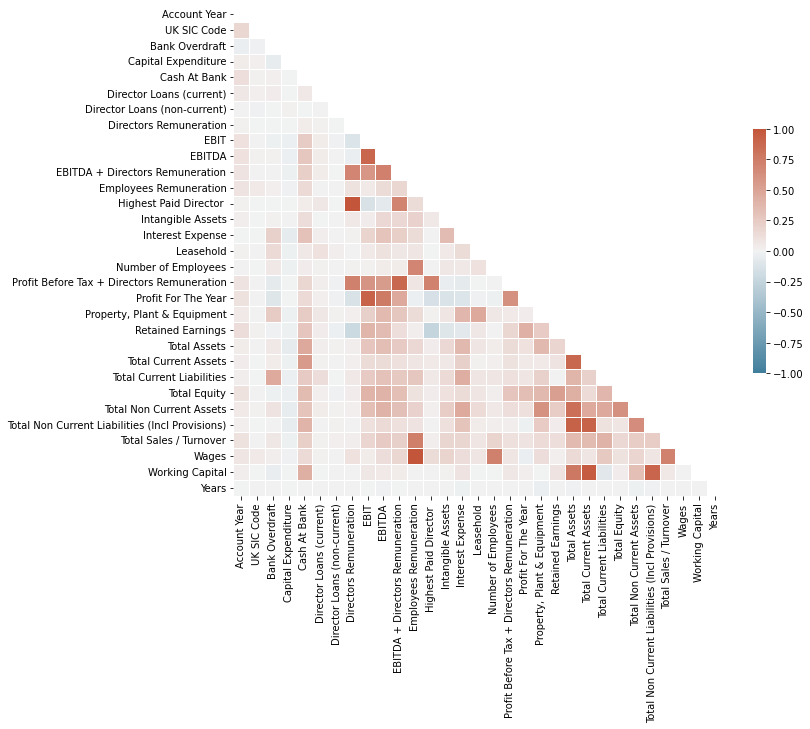

In [11]:
corr = df5.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

According to my searches, some vairables of interest include:

- working capital (current assets - current liabilities)
- total equity (total assets - total liability)
- 



For Directors Remuneration, this can be calculated directly by subtracting EBITDA from EBITDA + Directors Remuneration. There are 3444 missing, once filled this reduces to 1732.

For Total Assets, this can be calculated directly by adding Total Current Assets and Total Non Current Assets.

In [12]:
df5['Directors Remuneration'].fillna(df5['EBITDA + Directors Remuneration'] - df5['EBITDA'], inplace=True)
df5['Total Assets'].fillna(df5['Total Current Assets'] + df5['Total Non Current Assets'], inplace=True)
df5['Working Capital'].fillna(df5['Total Current Assets'] + df5['Total Current Liabilities'], inplace=True)

Check how much data is missing from each column.

In [13]:
df5.isna().sum().sort_values()

Registered Number                                     0
UK SIC Code                                           0
Trading Status                                        0
Years                                                 0
Latest Accounts Date                                  0
Account Year                                          0
Date of Incorporation                                 1
Total Equity                                         15
Total Current Liabilities                            15
Total Current Assets                                 15
Working Capital                                      15
Total Non Current Assets                             16
Total Assets                                         16
Registered or Trading Postcode                       17
Total Non Current Liabilities (Incl Provisions)      17
Retained Earnings                                    49
Property, Plant & Equipment                         105
Cash At Bank                                    

I then drop the EBITDA + Directors Remuneration column as this is a combination of two other columns. I have also chosen to drop registered number as this is a unique number for each business, as well as the postcodes.

In [28]:
df6 = df5.drop(columns=['Registered Number','Account Year', 'Date of Incorporation', 'UK SIC Code',
                                'Bank Postcode', 'Registered or Trading Postcode', 'EBITDA + Directors Remuneration',
                                'Director Loans (current)', 'Director Loans (non-current)', 'Highest Paid Director ',
                                'Latest Accounts Date', 'Profit Before Tax + Directors Remuneration',
                                'EBIT', 'Highest Paid Director ', 'Total Non Current Liabilities (Incl Provisions)', 
                                'Wages', 'Working Capital', 'Leasehold', 'Bank Overdraft', 'Capital Expenditure'])

In [31]:
df6.isna().sum()

Trading Status                    0
Cash At Bank                    189
Directors Remuneration         1732
EBITDA                         1836
Employees Remuneration         3118
Intangible Assets               233
Interest Expense               1846
Number of Employees            1774
Profit For The Year            1836
Property, Plant & Equipment     105
Retained Earnings                49
Total Assets                     16
Total Current Assets             15
Total Current Liabilities        15
Total Equity                     15
Total Non Current Assets         16
Total Sales / Turnover         2125
Years                             0
dtype: int64

In [29]:
df7 = df6.dropna(how='any')

In [32]:
xdf = df7.drop(['Trading Status'], axis=1)
ydf = df7['Trading Status']

In [33]:
scx = MinMaxScaler()
scaled_x = scx.fit_transform(xdf)

In [34]:
y = ydf.to_numpy()
X = xdf.to_numpy()

In [35]:
print(y.shape)
print(X.shape)

(9864,)
(9864, 17)


In [36]:
model = RandomForestClassifier(random_state=0)

In [37]:
rfe = RFECV(model)
rfe = rfe.fit(X, y)

for i in range(X.shape[1]):
    print('Selected %s, Rank: %.3f, Column: %s' % (rfe.support_[i], rfe.ranking_[i], xdf.columns[i]))

Selected True, Rank: 1.000, Column: Cash At Bank
Selected True, Rank: 1.000, Column: Directors Remuneration
Selected True, Rank: 1.000, Column: EBITDA
Selected True, Rank: 1.000, Column: Employees Remuneration
Selected True, Rank: 1.000, Column: Intangible Assets
Selected True, Rank: 1.000, Column: Interest Expense
Selected True, Rank: 1.000, Column: Number of Employees
Selected True, Rank: 1.000, Column: Profit For The Year
Selected True, Rank: 1.000, Column: Property, Plant & Equipment
Selected True, Rank: 1.000, Column: Retained Earnings
Selected True, Rank: 1.000, Column: Total Assets
Selected True, Rank: 1.000, Column: Total Current Assets
Selected True, Rank: 1.000, Column: Total Current Liabilities
Selected True, Rank: 1.000, Column: Total Equity
Selected True, Rank: 1.000, Column: Total Non Current Assets
Selected True, Rank: 1.000, Column: Total Sales / Turnover
Selected True, Rank: 1.000, Column: Years


In [38]:
x_df = df6.dropna(how='any').drop(['Trading Status'], axis=1)
y_df = df6.dropna(how='any')['Trading Status']
X_rfe = x_df[x_df.columns[rfe.get_support(1)]]
# X_r = scx.fit_transform(X_rfe)

In [39]:
X_rfe

,Cash At Bank,Directors Remuneration,EBITDA,Employees Remuneration,Intangible Assets,Interest Expense,Number of Employees,Profit For The Year,"Property, Plant & Equipment",Retained Earnings,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Non Current Assets,Total Sales / Turnover,Years
0,1143.0,180449,-346093,1629707,0,309059,57,-636762,5576567,617128,7216172.0,1540296.0,3419378,3249408,5675876.0,5611658,68
5,1584330.0,225190,485428,1170260,0,0,17,367362,43881,631673,4788564.0,4744683.0,4156879,631685,43881.0,14269555,15
20,1656000.0,113000,3090000,4468000,1510000,71000,86,1840000,8158000,10582000,31067000.0,21399000.0,6889000,23035000,9668000.0,66895000,19
25,591774.0,40000,365567,557669,30000,16528,28,110590,50645,436084,5712483.0,5631837.0,5266676,436184,80646.0,20038992,3
30,664212.0,390248,-535858,15824628,55798,62991,729,-1074917,1991751,-1029706,11003412.0,8955863.0,3811858,1970296,2047549.0,25046348,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68610,118479.0,574880,235039,2437239,16917,36218,66,65254,434157,653705,3158195.0,2707021.0,2269303,728705,451174.0,7828873,16
68615,1005.0,387582,191424,2559961,188792,127185,132,-50396,906180,902091,4828909.0,3545177.0,3100406,1460111,1283732.0,6948421,9
68620,63280.0,239199,274681,5374450,0,31579,246,64520,987168,966728,4927909.0,3940566.0,3249187,977228,987343.0,17484716,18
68640,952128.0,215105,428579,4380023,0,48106,146,313765,986118,1612441,7905433.0,6912265.0,5733852,2102130,993168.0,19058892,63


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size = 0.2, random_state=0)

In [41]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [42]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [43]:
print(classification_report(y_test, y_pred, target_names=model.classes_))

              precision    recall  f1-score   support

     Default       0.73      0.44      0.55       348
 Non-default       0.89      0.96      0.93      1625

    accuracy                           0.87      1973
   macro avg       0.81      0.70      0.74      1973
weighted avg       0.86      0.87      0.86      1973



In [44]:
print(confusion_matrix(y_test, y_pred))

[[ 153  195]
 [  58 1567]]


In [141]:
filename = 'classification.sav'
pickle.dump(model, open(filename, 'wb'))